In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import PIL

In [38]:
# function to verify the image is supported by PIL lib
def verifyImageAndCopy(imagePath , copyTo):
    try:
        img = PIL.Image.open(imagePath)
        shutil.copy(imagePath , copyTo)
    except PIL.UnidentifiedImageError:
        print("skipping")

In [5]:
# all shapes - Octagon , Triangle , Nonagon , Star , Hexagon , Square , Heptagon , Pentagon , Circle
shapes_list = ["Octagon" , "Triangle" , "Nonagon" , "Star" , "Hexagon" , "Square" , "Heptagon" , "Pentagon" , "Circle"]


In [39]:
# generating folders
for i in shapes_list:
    os.system(f"rm -rf data/train/{i}")
    os.system(f"rm -rf data/valid/{i}")
    os.system(f"rm -rf data/test/{i}")
    os.makedirs(f'data/train/{i}')
    os.makedirs(f'data/valid/{i}')
    os.makedirs(f'data/test/{i}')

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import uuid

# function to generate 3 more agumented images
def generate_augmented_images(image_path , saveTo , count = 3):
    gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., brightness_range=[0.2,1.2] , horizontal_flip=True)
    
    # converting image to 500 , 500 pixel to make augmentation work
    im = PIL.Image.open(image_path)
    basewidth = 500
    wpercent = (basewidth/float(im.size[0]))
    hsize = int((float(im.size[1])*float(wpercent)))
    im = im.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
    
    image = np.expand_dims(im,0)
    
    aug_iter = gen.flow(image, save_to_dir=saveTo, save_prefix=f'aug-image-{uuid.uuid4()}-', save_format='jpeg')
    
    tempCount = 1
    for i in aug_iter:
        if(tempCount >= count):
            break
        tempCount = tempCount + 1

In [41]:
from IPython.display import clear_output

dataset_path = "predatasets/Dataset_5/output/"

# copying all shapes into respective train test and valid folders
for shape in shapes_list:
    print(f"\non {shape}")
    
    allImages = []
    
    for i in glob.glob(f"{dataset_path}/{shape}*"):
        allImages.append(i)
    
    # shuffle images for better training
    random.shuffle(allImages)

    # using 60 % data as train
    # using 20 % data as valid
    # using 20 % data as test
    
    len_allImages = len(allImages)
    
    train_len = int(60 / 100 * len_allImages)
    valid_len = int(20 / 100 * len_allImages)
    test_len = int(20 / 100 * len_allImages)
    
    # copy train
    for count , i in enumerate(allImages[:train_len]):
        print(f"\r{count} / {train_len}" , end="")
        generate_augmented_images(i , f'data/train/{shape}')
        verifyImageAndCopy(i , f'data/train/{shape}')
        
    # copy valid
    for i in allImages[train_len : train_len + valid_len]:
        verifyImageAndCopy(i , f'data/valid/{shape}')
        
    # copy test
    for i in allImages[train_len + valid_len : train_len + valid_len + test_len]:
        verifyImageAndCopy(i , f'data/test/{shape}')


on Octagon
5999 / 6000
on Triangle
5999 / 6000
on Nonagon
5999 / 6000
on Star
5999 / 6000
on Hexagon
5999 / 6000
on Square
5999 / 6000
on Heptagon
5999 / 6000
on Pentagon
5999 / 6000
on Circle
5999 / 6000

In [3]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [6]:

# converting data into batches
# target size = height and width of the images we want images to be resized to [for reduced complexity]
# classes = all output classes
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=shapes_list, batch_size=25)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=shapes_list, batch_size=25)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=shapes_list, batch_size=25, shuffle=False)

Found 215981 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.


In [7]:
# get first batch images and labels
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 25, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

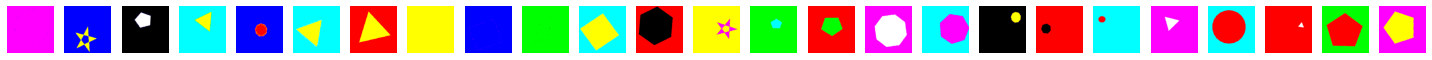

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

In [10]:
from tensorflow.keras.models import load_model
model = load_model('saved_model.h5')

2022-03-18 20:38:14.998730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 20:38:14.999218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 20:38:14.999345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-18 20:38:14.999436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-18 20:38:15.043402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 9)                 1

In [12]:
import pickle

with open("model_history.bin" , "rb") as file:
    encoded = file.read()

history = pickle.loads(encoded)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


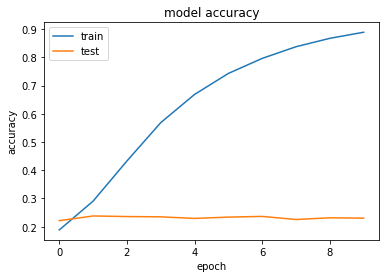

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

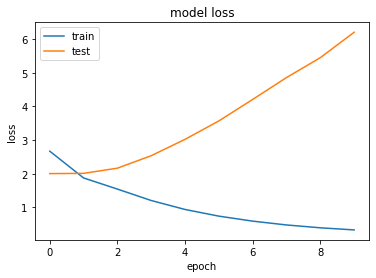

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

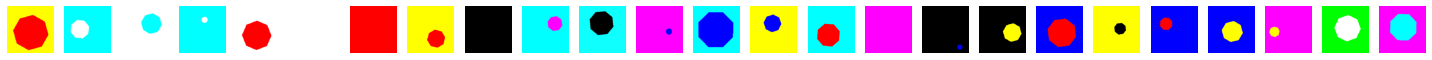

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
plotImages(test_imgs)
print(test_labels)

In [20]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

2022-03-18 20:43:39.821415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160563200 exceeds 10% of free system memory.


  1/720 [..............................] - ETA: 9:48

2022-03-18 20:43:40.160251: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 80281600 exceeds 10% of free system memory.
2022-03-18 20:43:40.350065: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160563200 exceeds 10% of free system memory.


  2/720 [..............................] - ETA: 5:10

2022-03-18 20:43:40.601375: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 80281600 exceeds 10% of free system memory.
2022-03-18 20:43:40.783706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 160563200 exceeds 10% of free system memory.


720/720 [==============================] - 271s 376ms/step


In [21]:
np.round(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [22]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 284  137  341   40  242  179  312  207  258]
 [  99  675   86  333  104  339  116  152   96]
 [ 321  114  308   39  241  164  294  180  339]
 [  36  466   36 1100   65  154   38   70   35]
 [ 261  191  242   47  268  241  289  282  179]
 [ 166  284  132  101  217  480  190  289  141]
 [ 287  132  284   55  225  197  309  247  264]
 [ 206  193  224   58  266  304  250  322  177]
 [ 302   96  334   44  196  146  310  154  418]]


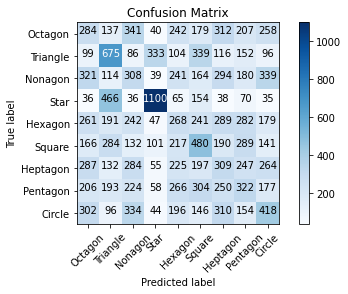

In [25]:
cm_plot_labels = shapes_list
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [26]:
print(model.evaluate(x=test_batches, steps=len(test_batches), verbose=1))

720/720 [==============================] - 261s 362ms/step - loss: 6.2407 - accuracy: 0.2313
[6.240664958953857, 0.23133333027362823]


In [29]:
# model is overfitting

train valid test ratio = 60 20 20
Learning rate in optimization algorithms (e.g. gradient descent) = 0.0001
Choice of optimization algorithm = Adam optimizer
Choice of activation function = relu for convolution layer and softmax for Dense layer
The choice of cost or loss function = categorical_crossentropy
Number of hidden layers in ANN = 5
Number of iterations (epochs) in training ANN = 10
Kernel size in convolutional layers = 3,3
filter size in convolutional layers = 32 in one and 64 in other